##Imports & Setup

In [30]:
#Install necessary packages
!pip install opendatasets opencv-python-headless --quiet

#Standard Libraries
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import pandas as pd
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import opendatasets as od
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import RandomErasing
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.mobile_optimizer import optimize_for_mobile

#Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Imports ok. PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")


Imports ok. PyTorch device: cuda


##Download & Combine Datasets

In [2]:
#Download Datasets
od.download("https://www.kaggle.com/datasets/seroshkarim/cotton-leaf-disease-dataset")
od.download("https://www.kaggle.com/datasets/jayaprakashpondy/wheat-leaf-disease")

#Paths
wheat_path = "/content/wheat-leaf-disease/Dataset"
cotton_path = "/content/cotton-leaf-disease-dataset/cotton"
combined_path = "/content/combined_dataset"
os.makedirs(combined_path, exist_ok=True)

def move_images(src_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for fname in os.listdir(src_folder):
        src = os.path.join(src_folder, fname)
        if os.path.isfile(src):
            shutil.copy(src, dest_folder)

# Wheat Classes
move_images(os.path.join(wheat_path, "Brown rust"), os.path.join(combined_path, "wheat_brown_rust"))
move_images(os.path.join(wheat_path, "Healthy"), os.path.join(combined_path, "wheat_healthy"))
move_images(os.path.join(wheat_path, "Loose Smut"), os.path.join(combined_path, "wheat_loose_smut"))

#Cotton Classes
for folder in os.listdir(cotton_path):
    move_images(os.path.join(cotton_path, folder), os.path.join(combined_path, f"cotton_{folder}"))

print("Combined dataset at:", combined_path)
for cls in sorted(os.listdir(combined_path)):
    p = os.path.join(combined_path, cls)
    if os.path.isdir(p):
        print(cls, ":", len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p,f))]))


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chabdullah7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seroshkarim/cotton-leaf-disease-dataset


100%|██████████| 181M/181M [00:00<00:00, 1.29GB/s]

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chabdullah7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/wheat-leaf-disease


100%|██████████| 1.59G/1.59G [00:14<00:00, 120MB/s] 

Combined dataset at: /content/combined_dataset
cotton_bacterial_blight : 448
cotton_curl_virus : 418
cotton_fussarium_wilt : 419
cotton_healthy : 426
wheat_brown_rust : 1256
wheat_healthy : 1658
wheat_loose_smut : 939


##Augmentation

In [3]:
#Augmentations
class RandomBlurSharpen(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() < self.p:
            arr = np.array(img)
            if random.random() < 0.5:
                #Gaussian Blur
                arr = cv2.GaussianBlur(arr, (3,3), 0)
            else:
                #Sharpen
                kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
                arr = cv2.filter2D(arr, -1, kernel)
            return Image.fromarray(arr.astype(np.uint8))
        return img

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.03):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        #Tensor in [0,1]
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy = tensor + noise.to(tensor.device)
        return torch.clamp(noisy, 0., 1.)

##Transforms & DataLoaders

In [4]:
#Hyperparameters
img_size = 128
batch_size = 32
num_workers = 2

#Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    RandomBlurSharpen(p=0.5),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.03),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.15), ratio=(0.3,3.3), value='random')
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

#Dataset + Split
dataset = datasets.ImageFolder(combined_path, transform=train_transforms)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
val_data.dataset.transform = val_transforms

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Train size:", len(train_data), "Val size:", len(val_data))

Classes: ['cotton_bacterial_blight', 'cotton_curl_virus', 'cotton_fussarium_wilt', 'cotton_healthy', 'wheat_brown_rust', 'wheat_healthy', 'wheat_loose_smut']
Device: cuda
Train size: 4389 Val size: 1098


##Class Weights & Loss

In [5]:
# Compute Class Weights
train_targets = [label for _, label in train_data]
class_count = Counter(train_targets)
counts_list = [class_count[i] for i in range(num_classes)]
print("Train class counts:", counts_list)

#Inverse Frequency Weights, Normalized
cw = torch.tensor([1.0 / c for c in counts_list], dtype=torch.float32)
cw = cw / cw.sum() * num_classes
cw = cw.to(device)
print("Applied class weights:", cw)

# Focal Loss (as nn.Module) with class weights
class FocalLossModule(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        #Inputs: Logits
        ce = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

use_focal = True
if use_focal:
    criterion = FocalLossModule(weight=cw)
else:
    criterion = nn.CrossEntropyLoss(weight=cw)
print("Using Focal Loss:" if use_focal else "Using CrossEntropyLoss (weighted)")

Train class counts: [355, 336, 334, 329, 1025, 1258, 752]
Applied class weights: tensor([1.3210, 1.3957, 1.4040, 1.4254, 0.4575, 0.3728, 0.6236],
       device='cuda:0')
Using Focal Loss:


##CNN Architecture

In [6]:
class CropCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.3),

            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.4), nn.Linear(128, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CropCNN(num_classes).to(device)
print(model)


CropCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

##MixUp & CutMix Utilities

In [11]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size, C, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

#Mix Probabilities
mixup_prob = 0.4
cutmix_prob = 0.3

##Optimizer & OneCycleLR Scheduler

In [12]:
#Hyperparameters
epochs = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

print("OneCycleLR ready — steps_per_epoch:", steps_per_epoch)

OneCycleLR ready — steps_per_epoch: 138


##Training Loop

In [13]:
best_val_loss = np.inf
patience = 7
no_improve = 0

train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", ncols=100)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        r = random.random()
        if r < mixup_prob:
            #MixUp
            mixed_x, y_a, y_b, lam = mixup_data(images, labels, alpha=0.4)
            outputs = model(mixed_x)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        elif r < mixup_prob + cutmix_prob:
            #CutMix
            mixed_x, y_a, y_b, lam = cutmix_data(images.clone(), labels, alpha=1.0)
            outputs = model(mixed_x)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{running_loss / (pbar.n + 1):.4f}"})

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    #Early Stopping & Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'class_names': class_names
        }, "best_advanced_crop_model.pth")
        print("Saved best_advanced_crop_model.pth")
        no_improve = 0
    else:
        no_improve += 1
        print(f"No improvement: {no_improve}/{patience}")
        if no_improve >= patience:
            print("Early stopping triggered")
            break

print("Training finished. Best Val Loss:", best_val_loss)

Epoch 1/50: 100%|████████████████████████████████████| 138/138 [00:37<00:00,  3.70it/s, loss=0.7042]


Epoch 1 | Train Loss: 0.6991 | Val Loss: 1.5575 | Val Acc: 17.67%
Saved best_advanced_crop_model.pth


Epoch 2/50: 100%|████████████████████████████████████| 138/138 [00:36<00:00,  3.74it/s, loss=0.5828]


Epoch 2 | Train Loss: 0.5828 | Val Loss: 1.3859 | Val Acc: 26.32%
Saved best_advanced_crop_model.pth


Epoch 3/50: 100%|████████████████████████████████████| 138/138 [00:36<00:00,  3.81it/s, loss=0.5500]


Epoch 3 | Train Loss: 0.5500 | Val Loss: 0.9837 | Val Acc: 29.69%
Saved best_advanced_crop_model.pth


Epoch 4/50: 100%|████████████████████████████████████| 138/138 [00:37<00:00,  3.70it/s, loss=0.5274]


Epoch 4 | Train Loss: 0.5274 | Val Loss: 0.6388 | Val Acc: 43.81%
Saved best_advanced_crop_model.pth


Epoch 5/50: 100%|████████████████████████████████████| 138/138 [00:36<00:00,  3.75it/s, loss=0.5287]


Epoch 5 | Train Loss: 0.5249 | Val Loss: 0.3829 | Val Acc: 63.02%
Saved best_advanced_crop_model.pth


Epoch 6/50: 100%|████████████████████████████████████| 138/138 [00:37<00:00,  3.63it/s, loss=0.4880]


Epoch 6 | Train Loss: 0.4845 | Val Loss: 0.5284 | Val Acc: 69.58%
No improvement: 1/7


Epoch 7/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.86it/s, loss=0.4683]


Epoch 7 | Train Loss: 0.4683 | Val Loss: 0.4362 | Val Acc: 67.40%
No improvement: 2/7


Epoch 8/50: 100%|████████████████████████████████████| 138/138 [00:36<00:00,  3.80it/s, loss=0.4715]


Epoch 8 | Train Loss: 0.4681 | Val Loss: 0.3184 | Val Acc: 50.64%
Saved best_advanced_crop_model.pth


Epoch 9/50: 100%|████████████████████████████████████| 138/138 [00:35<00:00,  3.91it/s, loss=0.4325]


Epoch 9 | Train Loss: 0.4325 | Val Loss: 0.4059 | Val Acc: 59.56%
No improvement: 1/7


Epoch 10/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.73it/s, loss=0.4164]


Epoch 10 | Train Loss: 0.4133 | Val Loss: 0.3531 | Val Acc: 59.56%
No improvement: 2/7


Epoch 11/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.85it/s, loss=0.3995]


Epoch 11 | Train Loss: 0.3966 | Val Loss: 0.3382 | Val Acc: 52.64%
No improvement: 3/7


Epoch 12/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.92it/s, loss=0.4082]


Epoch 12 | Train Loss: 0.4082 | Val Loss: 0.1994 | Val Acc: 79.51%
Saved best_advanced_crop_model.pth


Epoch 13/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.86it/s, loss=0.3822]


Epoch 13 | Train Loss: 0.3795 | Val Loss: 0.2243 | Val Acc: 70.86%
No improvement: 1/7


Epoch 14/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.72it/s, loss=0.3651]


Epoch 14 | Train Loss: 0.3651 | Val Loss: 0.2481 | Val Acc: 70.95%
No improvement: 2/7


Epoch 15/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.87it/s, loss=0.3677]


Epoch 15 | Train Loss: 0.3651 | Val Loss: 0.1606 | Val Acc: 87.70%
Saved best_advanced_crop_model.pth


Epoch 16/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.85it/s, loss=0.3505]


Epoch 16 | Train Loss: 0.3480 | Val Loss: 0.1731 | Val Acc: 84.24%
No improvement: 1/7


Epoch 17/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.98it/s, loss=0.3509]


Epoch 17 | Train Loss: 0.3509 | Val Loss: 0.2227 | Val Acc: 80.97%
No improvement: 2/7


Epoch 18/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.70it/s, loss=0.3211]


Epoch 18 | Train Loss: 0.3188 | Val Loss: 0.1327 | Val Acc: 85.15%
Saved best_advanced_crop_model.pth


Epoch 19/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.83it/s, loss=0.3276]


Epoch 19 | Train Loss: 0.3276 | Val Loss: 0.2062 | Val Acc: 82.60%
No improvement: 1/7


Epoch 20/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.94it/s, loss=0.3056]


Epoch 20 | Train Loss: 0.3034 | Val Loss: 0.2925 | Val Acc: 69.95%
No improvement: 2/7


Epoch 21/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.84it/s, loss=0.2668]


Epoch 21 | Train Loss: 0.2668 | Val Loss: 0.1148 | Val Acc: 89.53%
Saved best_advanced_crop_model.pth


Epoch 22/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.72it/s, loss=0.2513]


Epoch 22 | Train Loss: 0.2495 | Val Loss: 0.1320 | Val Acc: 86.07%
No improvement: 1/7


Epoch 23/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.85it/s, loss=0.2798]


Epoch 23 | Train Loss: 0.2798 | Val Loss: 0.1010 | Val Acc: 91.07%
Saved best_advanced_crop_model.pth


Epoch 24/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.86it/s, loss=0.2600]


Epoch 24 | Train Loss: 0.2581 | Val Loss: 0.1315 | Val Acc: 80.60%
No improvement: 1/7


Epoch 25/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.92it/s, loss=0.2815]


Epoch 25 | Train Loss: 0.2794 | Val Loss: 0.0715 | Val Acc: 86.43%
Saved best_advanced_crop_model.pth


Epoch 26/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.79it/s, loss=0.2585]


Epoch 26 | Train Loss: 0.2567 | Val Loss: 0.1303 | Val Acc: 84.61%
No improvement: 1/7


Epoch 27/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.82it/s, loss=0.2391]


Epoch 27 | Train Loss: 0.2391 | Val Loss: 0.0463 | Val Acc: 93.17%
Saved best_advanced_crop_model.pth


Epoch 28/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.82it/s, loss=0.2387]


Epoch 28 | Train Loss: 0.2370 | Val Loss: 0.0603 | Val Acc: 92.81%
No improvement: 1/7


Epoch 29/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.85it/s, loss=0.2461]


Epoch 29 | Train Loss: 0.2461 | Val Loss: 0.0547 | Val Acc: 90.98%
No improvement: 2/7


Epoch 30/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.80it/s, loss=0.2245]


Epoch 30 | Train Loss: 0.2228 | Val Loss: 0.0486 | Val Acc: 92.17%
No improvement: 3/7


Epoch 31/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.83it/s, loss=0.2372]


Epoch 31 | Train Loss: 0.2372 | Val Loss: 0.0610 | Val Acc: 93.72%
No improvement: 4/7


Epoch 32/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.80it/s, loss=0.2312]


Epoch 32 | Train Loss: 0.2312 | Val Loss: 0.0365 | Val Acc: 95.17%
Saved best_advanced_crop_model.pth


Epoch 33/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.86it/s, loss=0.2038]


Epoch 33 | Train Loss: 0.2038 | Val Loss: 0.0452 | Val Acc: 94.99%
No improvement: 1/7


Epoch 34/50: 100%|███████████████████████████████████| 138/138 [00:37<00:00,  3.72it/s, loss=0.2376]


Epoch 34 | Train Loss: 0.2376 | Val Loss: 0.0402 | Val Acc: 94.63%
No improvement: 2/7


Epoch 35/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.93it/s, loss=0.2221]


Epoch 35 | Train Loss: 0.2221 | Val Loss: 0.0393 | Val Acc: 94.17%
No improvement: 3/7


Epoch 36/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.82it/s, loss=0.1971]


Epoch 36 | Train Loss: 0.1957 | Val Loss: 0.0473 | Val Acc: 94.44%
No improvement: 4/7


Epoch 37/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.90it/s, loss=0.2025]


Epoch 37 | Train Loss: 0.2011 | Val Loss: 0.0317 | Val Acc: 94.99%
Saved best_advanced_crop_model.pth


Epoch 38/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.84it/s, loss=0.2279]


Epoch 38 | Train Loss: 0.2262 | Val Loss: 0.0333 | Val Acc: 95.54%
No improvement: 1/7


Epoch 39/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.85it/s, loss=0.1865]


Epoch 39 | Train Loss: 0.1865 | Val Loss: 0.0263 | Val Acc: 96.54%
Saved best_advanced_crop_model.pth


Epoch 40/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.87it/s, loss=0.1858]


Epoch 40 | Train Loss: 0.1858 | Val Loss: 0.0251 | Val Acc: 96.27%
Saved best_advanced_crop_model.pth


Epoch 41/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.89it/s, loss=0.1986]


Epoch 41 | Train Loss: 0.1972 | Val Loss: 0.0220 | Val Acc: 97.18%
Saved best_advanced_crop_model.pth


Epoch 42/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.83it/s, loss=0.1678]


Epoch 42 | Train Loss: 0.1678 | Val Loss: 0.0234 | Val Acc: 96.99%
No improvement: 1/7


Epoch 43/50: 100%|███████████████████████████████████| 138/138 [00:34<00:00,  3.95it/s, loss=0.1752]


Epoch 43 | Train Loss: 0.1752 | Val Loss: 0.0222 | Val Acc: 97.27%
No improvement: 2/7


Epoch 44/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.82it/s, loss=0.1640]


Epoch 44 | Train Loss: 0.1640 | Val Loss: 0.0231 | Val Acc: 97.09%
No improvement: 3/7


Epoch 45/50: 100%|███████████████████████████████████| 138/138 [00:36<00:00,  3.82it/s, loss=0.1832]


Epoch 45 | Train Loss: 0.1832 | Val Loss: 0.0235 | Val Acc: 97.63%
No improvement: 4/7


Epoch 46/50: 100%|███████████████████████████████████| 138/138 [00:45<00:00,  3.00it/s, loss=0.1979]


Epoch 46 | Train Loss: 0.1964 | Val Loss: 0.0214 | Val Acc: 96.90%
Saved best_advanced_crop_model.pth


Epoch 47/50: 100%|███████████████████████████████████| 138/138 [00:35<00:00,  3.86it/s, loss=0.1448]


Epoch 47 | Train Loss: 0.1448 | Val Loss: 0.0216 | Val Acc: 97.63%
No improvement: 1/7


Epoch 48/50: 100%|███████████████████████████████████| 138/138 [00:40<00:00,  3.42it/s, loss=0.1699]


Epoch 48 | Train Loss: 0.1686 | Val Loss: 0.0199 | Val Acc: 97.45%
Saved best_advanced_crop_model.pth


Epoch 49/50: 100%|███████████████████████████████████| 138/138 [00:43<00:00,  3.18it/s, loss=0.1945]


Epoch 49 | Train Loss: 0.1931 | Val Loss: 0.0212 | Val Acc: 97.63%
No improvement: 1/7


Epoch 50/50: 100%|███████████████████████████████████| 138/138 [00:40<00:00,  3.40it/s, loss=0.1680]


Epoch 50 | Train Loss: 0.1680 | Val Loss: 0.0202 | Val Acc: 97.72%
No improvement: 2/7
Training finished. Best Val Loss: 0.019879262894392014


##Plot Loss & Accuracy Curves

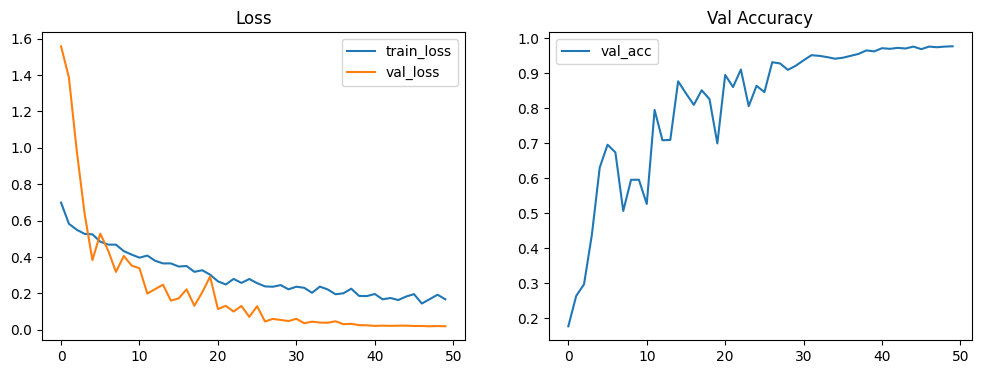

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(val_accs, label='val_acc')
plt.legend(); plt.title('Val Accuracy')
plt.show()


##Final Evaluation

Final Eval: 100%|██████████| 35/35 [00:09<00:00,  3.56it/s]


Final Val Accuracy: 0.9744990892531876

Classification Report:
                          precision    recall  f1-score   support

cotton_bacterial_blight     1.0000    1.0000    1.0000        93
      cotton_curl_virus     0.9639    0.9877    0.9756        81
  cotton_fussarium_wilt     0.9121    0.9765    0.9432        85
         cotton_healthy     0.9897    0.9897    0.9897        97
       wheat_brown_rust     0.9622    0.9913    0.9765       231
          wheat_healthy     0.9968    0.9459    0.9707       333
       wheat_loose_smut     0.9667    0.9775    0.9721       178

               accuracy                         0.9745      1098
              macro avg     0.9702    0.9812    0.9754      1098
           weighted avg     0.9753    0.9745    0.9746      1098



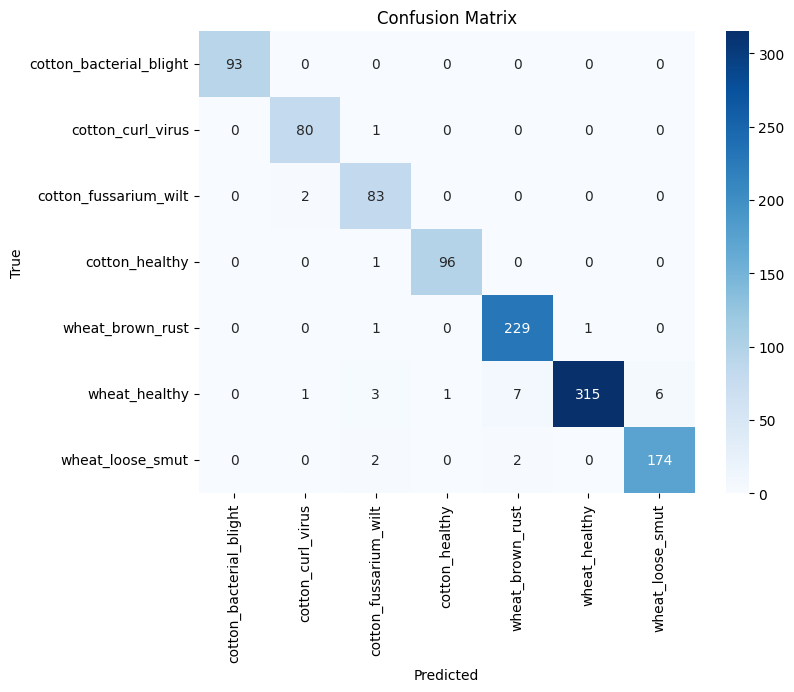

In [15]:
#Load Best Model
ckpt = torch.load("best_advanced_crop_model.pth", map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Eval"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Final Val Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


##Inference

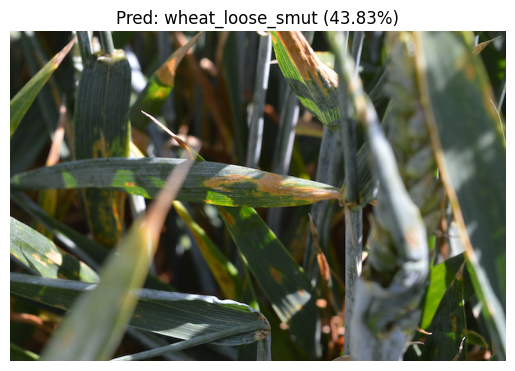

('wheat_loose_smut',
 array([0.010294  , 0.0406547 , 0.01364287, 0.00370177, 0.16572367,
        0.32773164, 0.4382514 ], dtype=float32))

In [17]:
from PIL import Image
def predict_image(img_path, show=True):
    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        idx = int(np.argmax(probs))
    if show:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {class_names[idx]} ({probs[idx]*100:.2f}%)")
        plt.show()
    return class_names[idx], probs

sample = "/content/Septoria672.png"
predict_image(sample)


##Grad-CAM

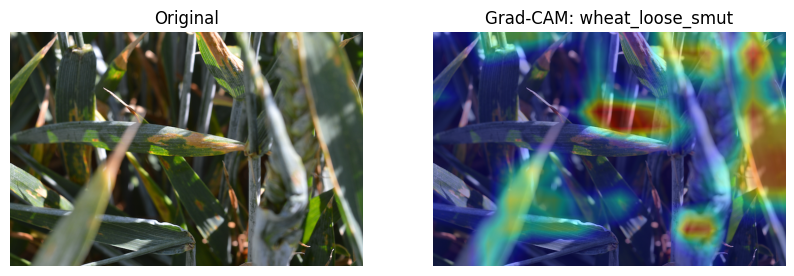

In [20]:
#Grad-CAM Implementation
def find_last_conv_layer(model):
    last_conv = None
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
            last_name = name
    return last_name, last_conv

#Set Hooks
def generate_gradcam(model, img_path, target_class=None):
    model.eval()
    #Find Last Conv
    last_name, last_conv = find_last_conv_layer(model)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in model.features")

    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    #Register Hooks
    h_f = last_conv.register_forward_hook(forward_hook)
    h_b = last_conv.register_backward_hook(backward_hook)

    #Prepare Image
    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    x.requires_grad = True

    #Forward
    outputs = model(x)
    if target_class is None:
        target_class = int(outputs.argmax(dim=1).item())

    #Backward on Target Ccore
    model.zero_grad()
    score = outputs[0, target_class]
    score.backward()

    #Hooked Activations and Gradients
    act = activations['value'][0]
    grad = gradients['value'][0]

    #Global Avg Pool of Gradients to get Weights
    weights = torch.mean(grad.view(grad.size(0), -1), dim=1)

    #Weighted Combination
    cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    cam = cam - cam.min()
    if cam.max() != 0:
        cam = cam / cam.max()

    #To CPU Numpy & Resize to Original Image
    cam_np = cam.cpu().numpy()
    h, w = img.size[1], img.size[0]
    cam_resized = cv2.resize(cam_np, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    #Show
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)); plt.title(f"Grad-CAM: {class_names[target_class]}")
    plt.axis('off')
    plt.show()

    #Remove Hooks
    h_f.remove(); h_b.remove()


generate_gradcam(model, sample, target_class=None)


##Save Model

In [21]:
torch.save(model.state_dict(), "/content/final_model_combo.pth")
print("Model saved successfully!")

Model saved successfully!


##Download Model

In [27]:
from google.colab import files
files.download("/content/best_advanced_crop_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Final Inference + Grad-CAM Visualization Cell

Model loaded and ready for inference!


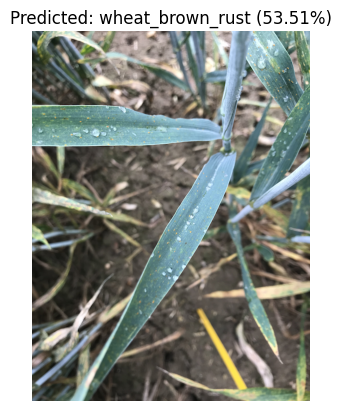

Predicted Class wheat_brown_rust


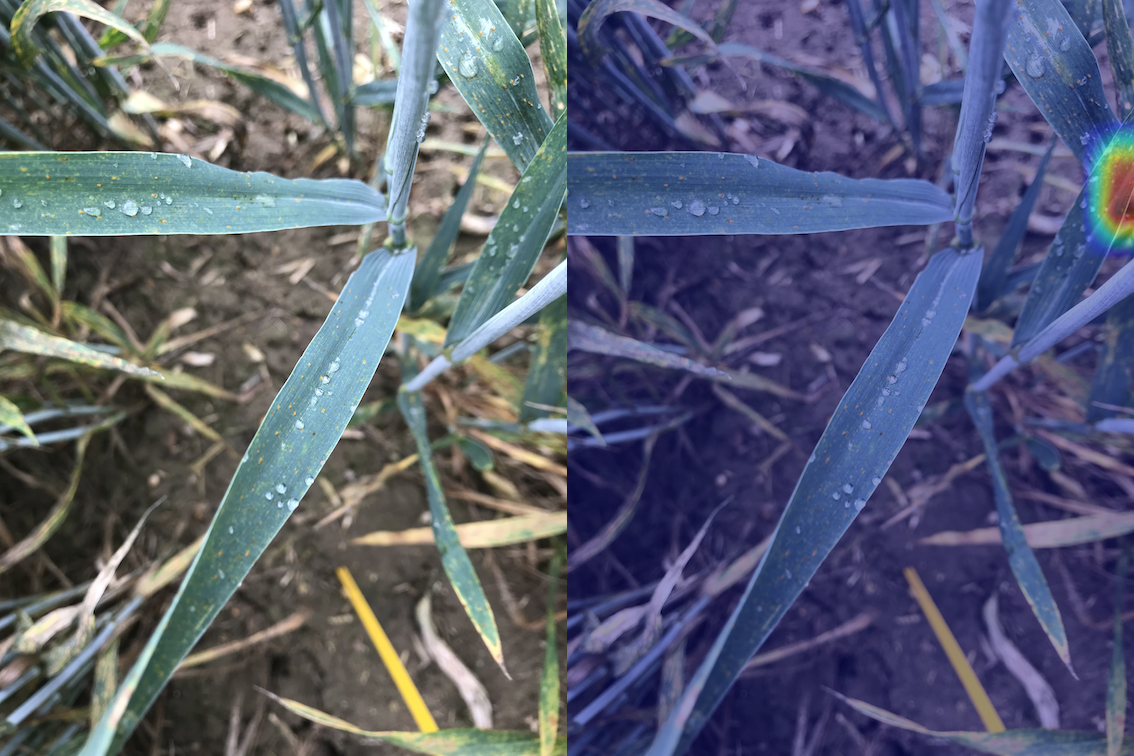

Grad-CAM image saved at: /content/gradcam_output.jpg


In [31]:
#Load Best Model
model.load_state_dict(torch.load("/content/final_model_combo.pth", map_location=device))
model.eval()
print("Model loaded and ready for inference!")

#Prediction Function
def predict_image(img_path, show=True):
    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        idx = int(np.argmax(probs))
    if show:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_names[idx]} ({probs[idx]*100:.2f}%)")
        plt.show()
    return class_names[idx], probs

#Grad-CAM Visualization
def generate_gradcam(model, img_path, target_class=None, save_path="/content/gradcam_output.jpg"):
    model.eval()

    #Find Last Conv Layer
    last_conv = None
    for name, module in model.features.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module

    activations, gradients = {}, {}

    def forward_hook(module, inp, out):
        activations['value'] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    #Register Hooks
    h_f = last_conv.register_forward_hook(forward_hook)
    h_b = last_conv.register_backward_hook(backward_hook)

    #Prepare Image
    img = Image.open(img_path).convert('RGB')
    x = val_transforms(img).unsqueeze(0).to(device)
    x.requires_grad = True

    #Forward + Backward
    outputs = model(x)
    if target_class is None:
        target_class = int(outputs.argmax(dim=1).item())
    model.zero_grad()
    outputs[0, target_class].backward()

    #Compute Grad-CAM
    act = activations['value'][0]
    grad = gradients['value'][0]
    weights = torch.mean(grad.view(grad.size(0), -1), dim=1)
    cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    cam_np = cam.cpu().numpy()

    #Overlay Heatmap
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    cam_resized = cv2.resize(cam_np, (img_cv.shape[1], img_cv.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    #Display (Original + Grad-CAM)
    combined = np.hstack((cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), superimposed))
    print(f"Predicted Class {class_names[target_class]}")
    cv2_imshow(combined)

    #Save Grad-CAM
    cv2.imwrite(save_path, superimposed)
    print(f"Grad-CAM image saved at: {save_path}")

    #Remove Hooks
    h_f.remove()
    h_b.remove()

#Example Usage
sample = "/content/wheat-leaf-disease/Dataset/Brown rust/BrownRust1018.png"
pred, probs = predict_image(sample)
generate_gradcam(model, sample)


##TorchScript Conversion & Saving for Mobile

In [34]:
#Load the checkpoint
checkpoint = torch.load("/content/best_advanced_crop_model.pth", map_location='cpu')

#Extract only the model weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')
model.eval()

print("Model loaded on CPU successfully!")

#Example input (for tracing)
example_input = torch.randn(1, 3, 224, 224)

#Convert to TorchScript
traced_model = torch.jit.trace(model, example_input)

#Save traced model
torch.jit.save(traced_model, "/content/best_advanced_crop_model_traced.pt")

print("TorchScript model saved successfully at: /content/best_advanced_crop_model_traced.pt")


Model loaded on CPU successfully!
TorchScript model saved successfully at: /content/best_advanced_crop_model_traced.pt


##Optimize TorchScript Model for Mobile

In [37]:
#Load the traced model
traced_model = torch.jit.load("/content/best_advanced_crop_model_traced.pt")

#Optimize
optimized_model = optimize_for_mobile(traced_model)

#Save optimized model
optimized_model_path = "/content/best_advanced_crop_model_mobile.pt"
optimized_model._save_for_lite_interpreter(optimized_model_path)

print(f"Mobile-optimized model saved successfully at: {optimized_model_path}")


Mobile-optimized model saved successfully at: /content/best_advanced_crop_model_mobile.pt


##Download Model

In [36]:
from google.colab import files
files.download("/content/best_advanced_crop_model_mobile.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>